Importing Libraries

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Transforming image to tensors

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Loading the cifar-10 dataset with the specified imbalances

In [40]:
from collections import Counter
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 5 classes we want
selected_classes = ['cat', 'dog', 'horse', 'deer', 'bird']
selected_class_indices = [full_train_dataset.class_to_idx[cls] for cls in selected_classes]
samples_per_class = {
    'cat': 4000,
    'dog': 1500,
    'horse': 1500,
    'deer': 1500,
    'bird': 1500
}

selected_indices = []
labels = np.array(full_train_dataset.targets)

for cls in selected_classes:
    cls_idx = full_train_dataset.class_to_idx[cls]
    cls_indices = np.where(labels == cls_idx)[0]
    sampled_indices = np.random.choice(cls_indices, samples_per_class[cls], replace=False)
    selected_indices.extend(sampled_indices)

imbalanced_subset = torch.utils.data.Subset(full_train_dataset, selected_indices)

print(f"Total samples in imbalanced dataset: {len(imbalanced_subset)}")
subset_labels = [full_train_dataset.targets[i] for i in selected_indices]
subset_class_names = [full_train_dataset.classes[i] for i in subset_labels]
print("Class distribution in subset:", Counter(subset_class_names))

dataloader = torch.utils.data.DataLoader(imbalanced_subset, batch_size=32, shuffle=True)

Total samples in imbalanced dataset: 10000
Class distribution in subset: Counter({'cat': 4000, 'dog': 1500, 'horse': 1500, 'deer': 1500, 'bird': 1500})


Defining GAN hyperparameters

In [41]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

Generator

In [42]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

Discriminator

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity

Initializing GAN components

In [44]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

Training

Epoch [1/10]                        Batch 100/313 Discriminator Loss: 0.4832 Generator Loss: 1.2430
Epoch [1/10]                        Batch 200/313 Discriminator Loss: 0.6820 Generator Loss: 0.9380
Epoch [1/10]                        Batch 300/313 Discriminator Loss: 0.5926 Generator Loss: 1.0372
Epoch [2/10]                        Batch 100/313 Discriminator Loss: 0.5402 Generator Loss: 1.0866
Epoch [2/10]                        Batch 200/313 Discriminator Loss: 0.6943 Generator Loss: 1.0603
Epoch [2/10]                        Batch 300/313 Discriminator Loss: 0.7338 Generator Loss: 0.7930
Epoch [3/10]                        Batch 100/313 Discriminator Loss: 0.7580 Generator Loss: 0.7669
Epoch [3/10]                        Batch 200/313 Discriminator Loss: 0.7034 Generator Loss: 1.0575
Epoch [3/10]                        Batch 300/313 Discriminator Loss: 0.6978 Generator Loss: 0.9779
Epoch [4/10]                        Batch 100/313 Discriminator Loss: 0.7758 Generator Loss: 0.8552


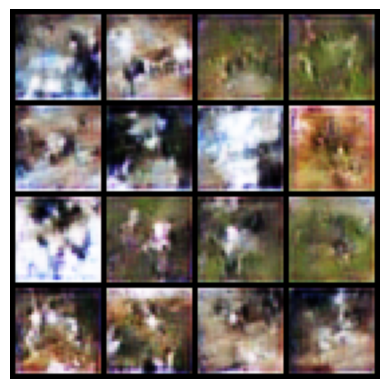

In [45]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):

        real_images = batch[0].to(device)

        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        real_images = real_images.to(device)

        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim, device=device)

        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_images = generator(z)

        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

Evaluating the FID and IS metrics

In [46]:
pip install torch-fidelity

Loading the saved weights of the generator and the discriminator

In [49]:
# # Instantiate your generator and discriminator models
# # Make sure to use the same architecture as during training
# generator = Generator(latent_dim).to(device)
# discriminator = Discriminator().to(device)

# # Load the saved state dictionaries
# generator.load_state_dict(torch.load('generator.pth',map_location=device))
# discriminator.load_state_dict(torch.load('discriminator.pth',map_location=device))

# print("Generator and discriminator weights loaded.")

Calculating the metrics

In [48]:
!pip install torchmetrics[image] -q

import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

latent_dim = 100  # The dimension of the noise vector for generator
num_images_to_eval = 100
batch_size = 128

class DummyGenerator(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 3 * 32 * 32),
            torch.nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 32, 32)
        return img

generator.eval() # setting the generator to eval mode


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
real_dataloader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size, shuffle=True)

Generating Fake Images
print(f"\nGenerating {num_images_to_eval} fake images...")
fake_images = []
with torch.no_grad():
    for _ in tqdm(range(0, num_images_to_eval, batch_size)):
        # number of images to generate in this batch
        current_batch_size = min(batch_size, num_images_to_eval - len(fake_images))
        if current_batch_size == 0:
            break

        # random noise and create images
        noise = torch.randn(current_batch_size, latent_dim, device=device)
        generated = generator(noise)
        generated = (generated * 0.5 + 0.5) * 255
        fake_images.append(generated.to(torch.uint8).cpu())

fake_images = torch.cat(fake_images, dim=0)
print("Fake images generated successfully.")

# Inception Score (IS)
print("\nCalculating Inception Score (IS)...")
inception_score = InceptionScore().to(device)
inception_score.update(fake_images.to(device))
is_mean, is_std = inception_score.compute()
print(f"Inception Score: {is_mean.item():.4f} ± {is_std.item():.4f}")

# Frechet Inception Distance (FID)
print("\nCalculating Frechet Inception Distance (FID)...")
fid = FrechetInceptionDistance(feature=64).to(device) # Use feature=64 for FID on CIFAR-10

for real_batch, _ in tqdm(real_dataloader, desc="Processing real images for FID"):
    # Convert real images from [-1, 1] to [0, 255] uint8
    real_batch = (real_batch * 0.5 + 0.5) * 255
    fid.update(real_batch.to(device, dtype=torch.uint8), real=True)

fake_dataset = torch.utils.data.TensorDataset(fake_images)
fake_dataloader = torch.utils.data.DataLoader(fake_dataset, batch_size=batch_size)

for fake_batch in tqdm(fake_dataloader, desc="Processing fake images for FID"):
    fid.update(fake_batch[0].to(device), real=False)

fid_score = fid.compute()
print(f"Frechet Inception Distance (FID): {fid_score.item():.4f}")

Using device: cuda

Generating 100 fake images...


100%|██████████| 1/1 [00:00<00:00, 84.65it/s]

Fake images generated successfully.

Calculating Inception Score (IS)...



/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception Score: 1.0750 ± 0.0218

Calculating Frechet Inception Distance (FID)...


Processing fake images for FID: 100%|██████████| 1/1 [00:00<00:00, 146.72it/s]

Frechet Inception Distance (FID): 5.9370
